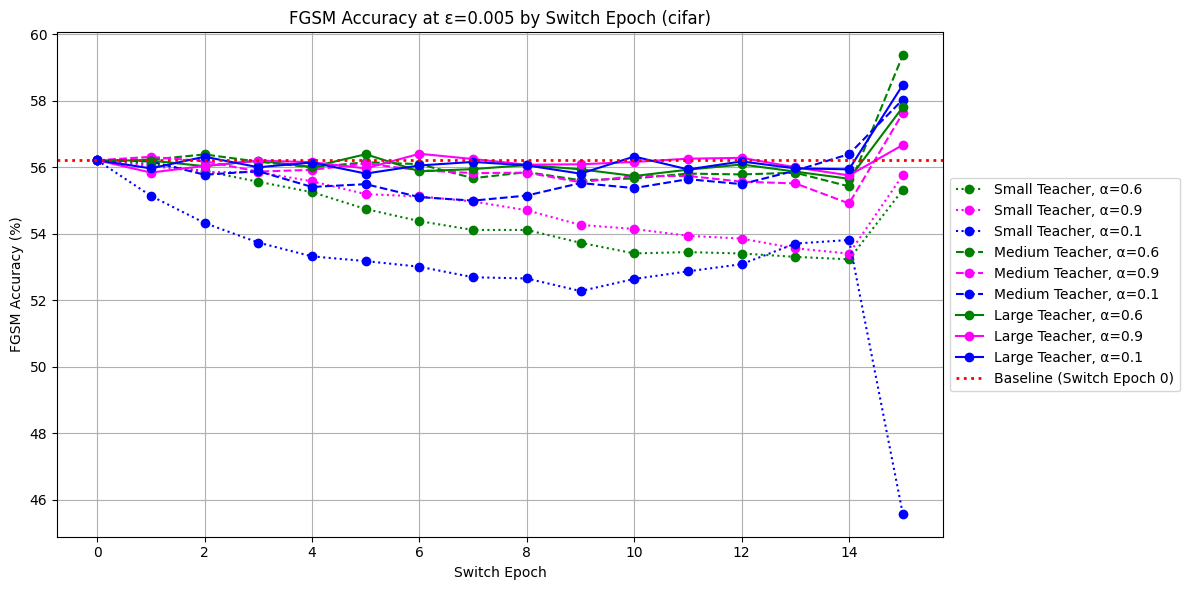

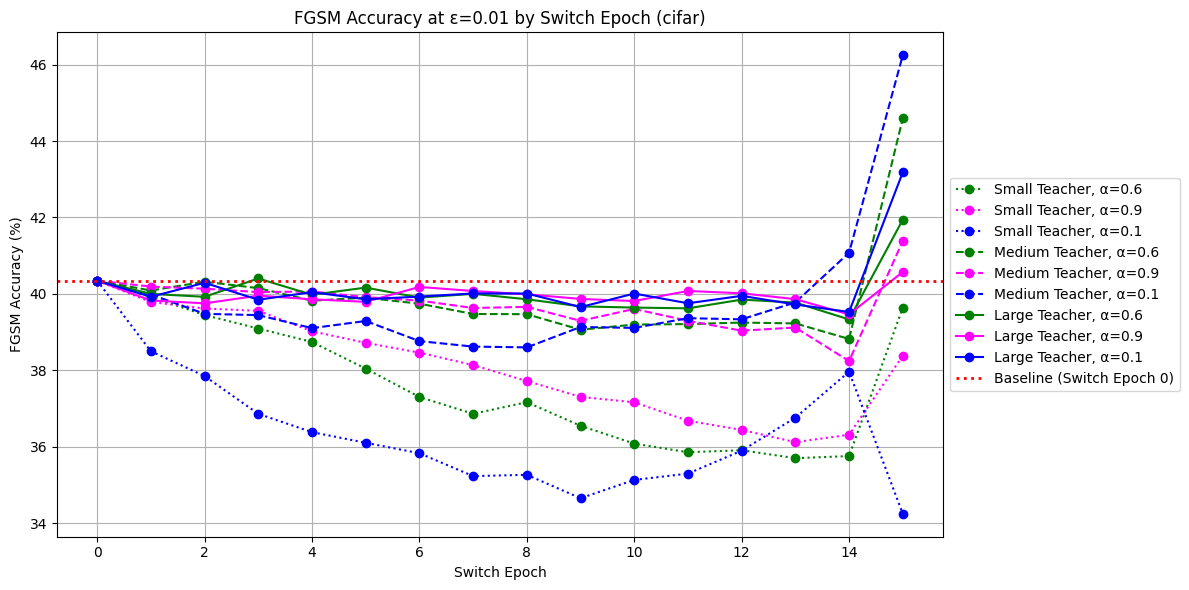

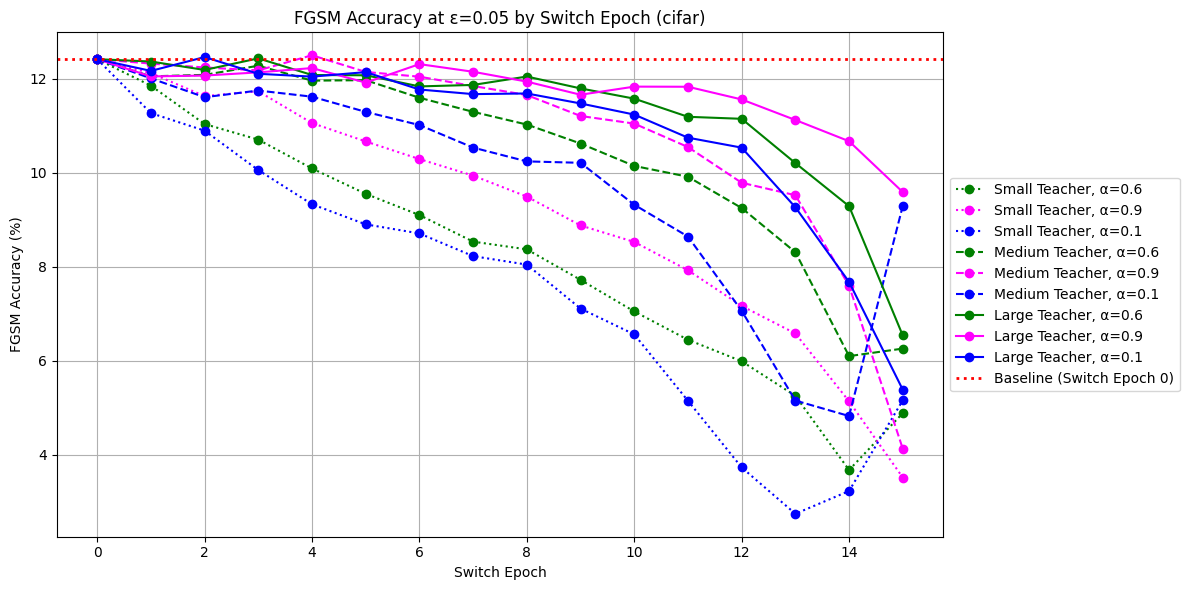

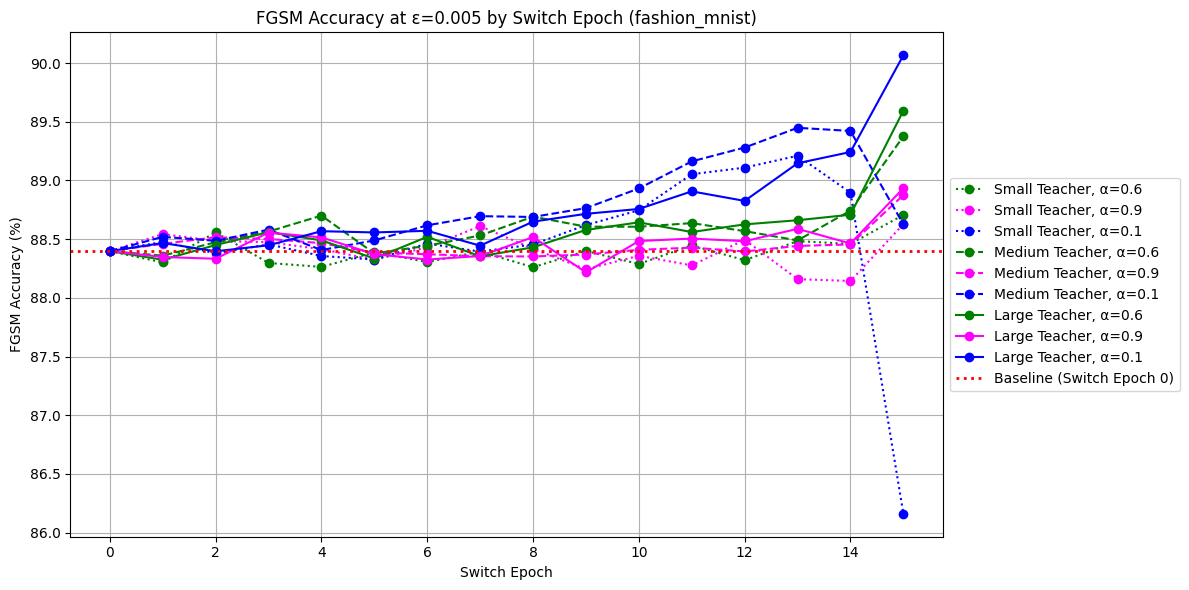

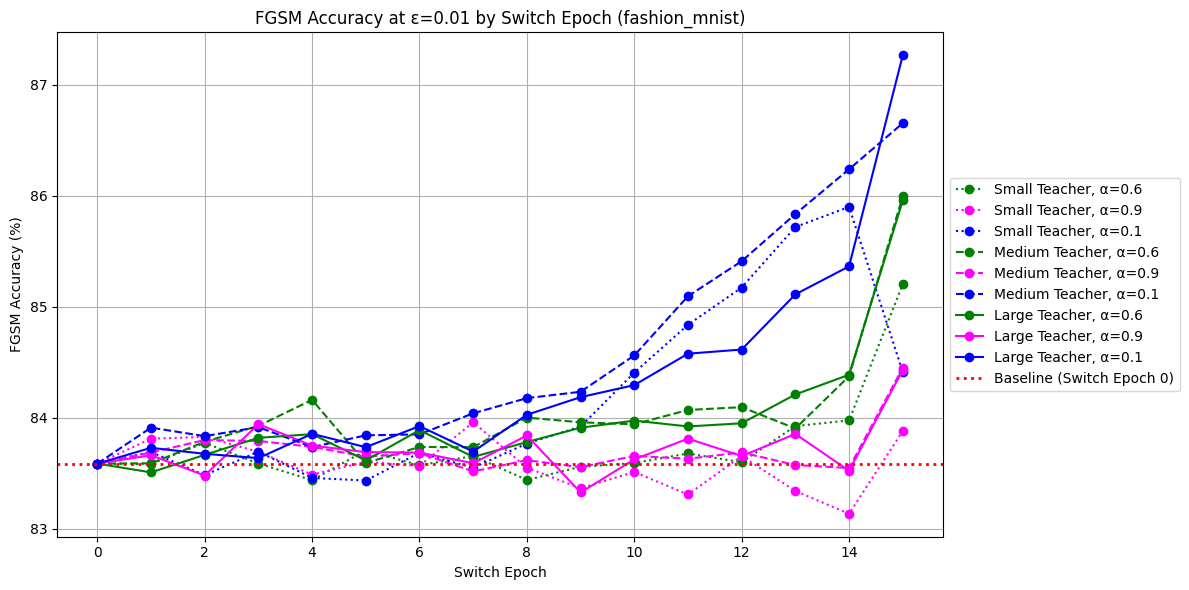

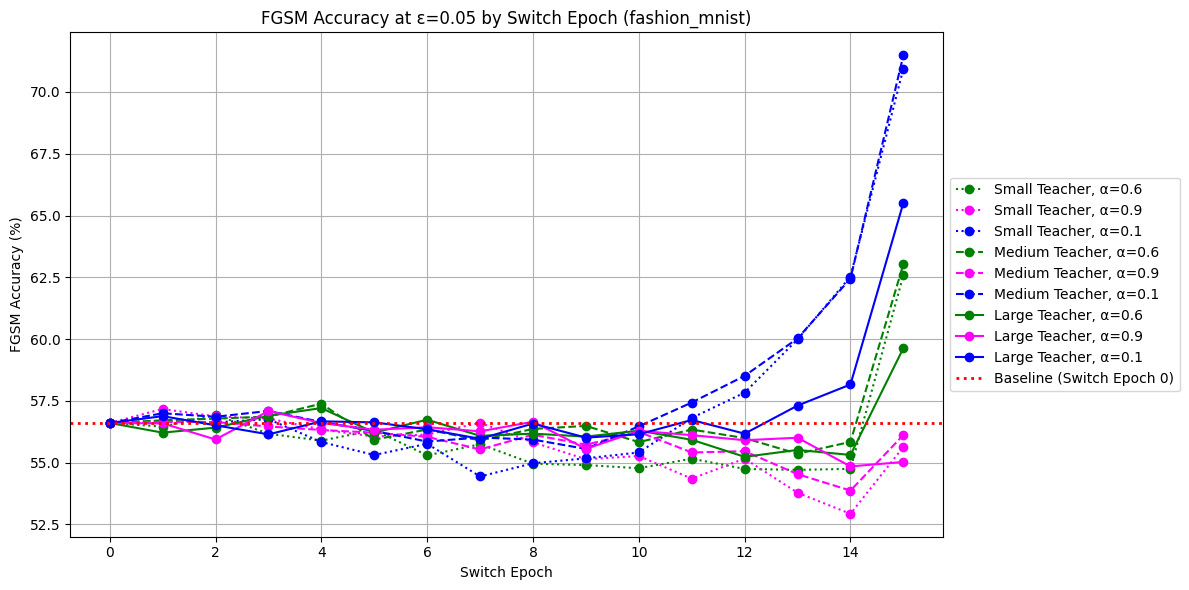

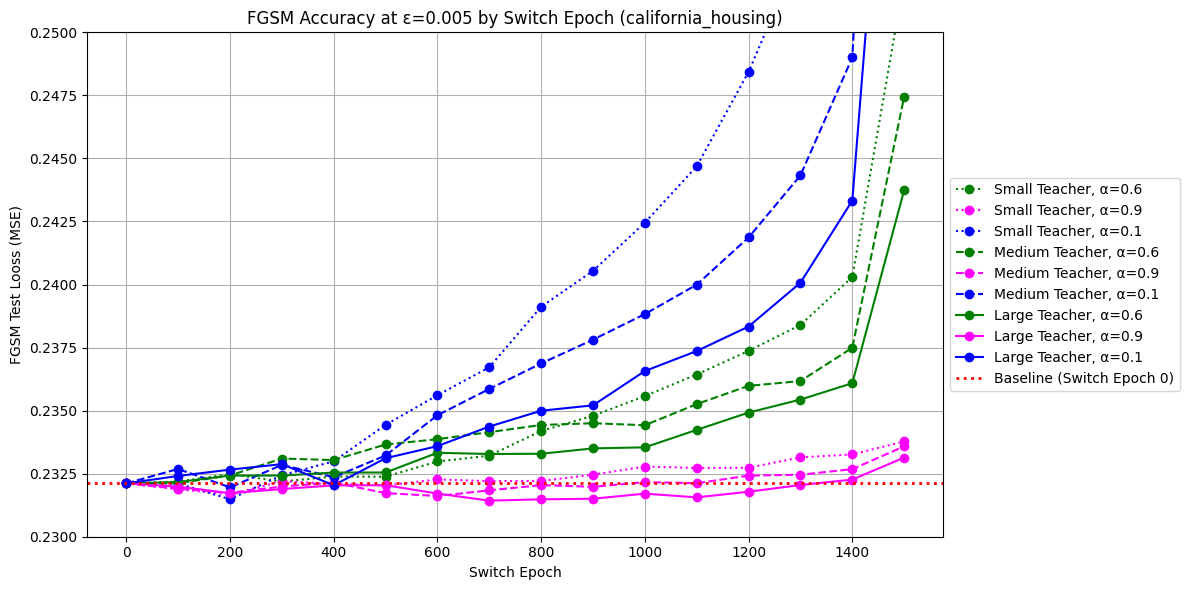

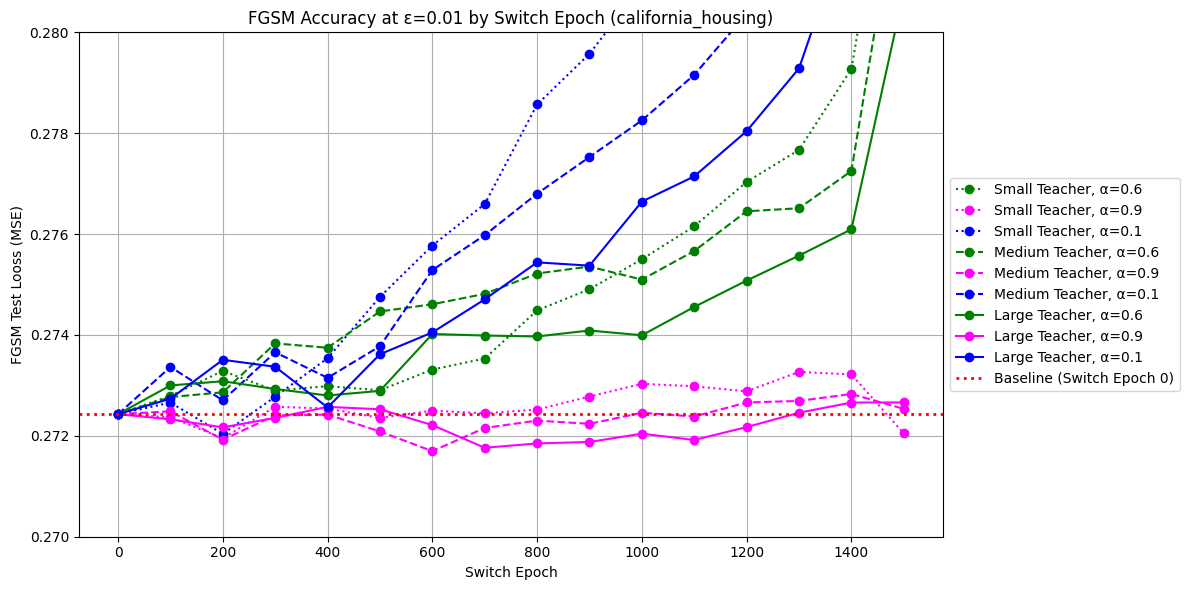

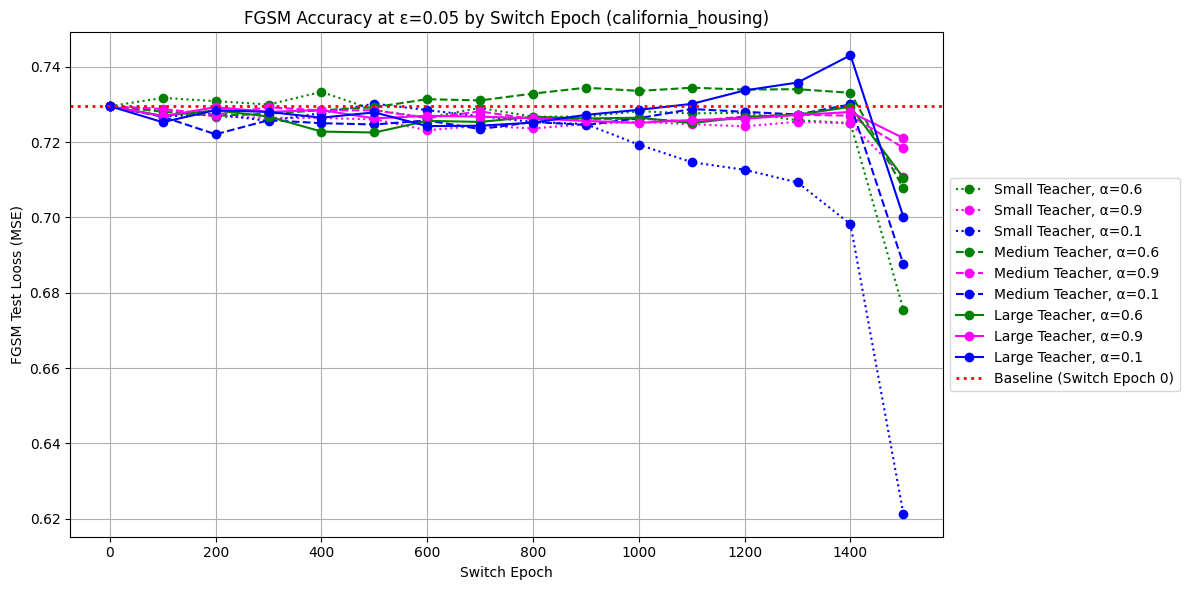

In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

output_dir = "../outputs"
seeds = np.loadtxt("../scripts/seeds.txt", dtype=int).tolist()
target_epsilons = [0.005, 0.01, 0.05]  # jako float
datasets = ["cifar", "fashion_mnist", "california_housing"]

for dataset in datasets:
    for target_epsilon in target_epsilons:
        alpha_colors = {
            "0_1": "blue",
            "0_6": "green",
            "0_9": "magenta"
        }
        teacher_styles = {
            "small": "dotted",
            "medium": "dashed",
            "large": "solid"
        }
        
        experiment_dirs = sorted([d for d in os.listdir(output_dir) if d.startswith("experiment")],
                                 key=lambda x: int(re.search(r'experiment(\d+)', x).group(1)))
        
        results = {}
        for exp_dir in experiment_dirs:
            if f"{dataset}" not in exp_dir:
                continue
        
            match = re.match(rf"experiment\d+_alpha_(\d_\d)_(\w+)_{dataset}", exp_dir)
            if not match:
                continue
        
            alpha, teacher_size = match.groups()
            label = f"{teacher_size.capitalize()} Teacher, α={alpha.replace('_', '.')}"
            path = os.path.join(output_dir, exp_dir)
        
            switch_epoch_accs = defaultdict(list)
        
            for seed in seeds:
                seed_dir = os.path.join(path, f"seed_{seed}")
                if not os.path.exists(seed_dir):
                    continue
        
                for switch_epoch_dir in os.listdir(seed_dir):
                    if not switch_epoch_dir.startswith("switch_epoch_"):
                        continue
        
                    switch_epoch = int(switch_epoch_dir.split("_")[-1])
                    csv_path = os.path.join(seed_dir, switch_epoch_dir, "fgsm_results.csv")
                    if not os.path.exists(csv_path):
                        continue
        
                    try:
                        df = pd.read_csv(csv_path)
                        df["epsilon"] = df["epsilon"].astype(float)  # důležité!
                        acc_row = df[df["epsilon"] == target_epsilon]
                        if not acc_row.empty:
                            acc = acc_row["accuracy"].values[0]
                            switch_epoch_accs[switch_epoch].append(acc)
                    except Exception as e:
                        print(f"Chyba při čtení {csv_path}: {e}")
        
            if not switch_epoch_accs:
                print(f"Žádná data pro {label}, přeskočeno.")
                continue
        
            x_vals = sorted(switch_epoch_accs.keys())
            y_vals = [np.mean(switch_epoch_accs[x]) for x in x_vals]
        
            color = alpha_colors.get(alpha, "black")
            linestyle = teacher_styles.get(teacher_size, "solid")
            results[label] = (x_vals, y_vals, color, linestyle)
        
        # VÝPOČET baseline
        baseline_vals = []
        for seed in seeds:
            student_csv = f"{output_dir}/student_{dataset}/model_seed_{seed}/fgsm_results.csv"
            if os.path.exists(student_csv):
                try:
                    df = pd.read_csv(student_csv)
                    df["epsilon"] = df["epsilon"].astype(float)
                    row = df[df["epsilon"] == target_epsilon]
                    if not row.empty:
                        baseline_vals.append(row["accuracy"].values[0])
                except Exception as e:
                    print(f"Chyba při čtení baseline: {e}")
        
        baseline_mean = np.mean(baseline_vals) if baseline_vals else None
        
        # Přidání bodu (0, baseline_mean) ke každé křivce
        if baseline_mean is not None:
            for key in results:
                x_vals, y_vals, color, linestyle = results[key]
                if 0 not in x_vals:
                    x_vals.insert(0, 0)
                    y_vals.insert(0, baseline_mean)
                results[key] = (x_vals, y_vals, color, linestyle)
        
        # === Vykreslení ===
        plt.figure(figsize=(12, 6))
        for label, (x, y, color, linestyle) in results.items():
            plt.plot(x, y, label=label, color=color, linestyle=linestyle, marker='o')
        
        # Čára baseline
        if baseline_mean is not None:
            plt.axhline(y=baseline_mean, color='red', linestyle='dotted', linewidth=2, label='Baseline (Switch Epoch 0)')
        
        plt.title(f"FGSM Accuracy at ε={target_epsilon} by Switch Epoch ({dataset})")
        plt.xlabel("Switch Epoch")
        
        plt.grid(True)
        if dataset == "california_housing":
            plt.ylabel("FGSM Test Looss (MSE)")
            if target_epsilon == 0.005:
                plt.ylim(0.23,0.25)
            elif target_epsilon == 0.01:
                plt.ylim(0.27,0.28)
        else:
            plt.ylabel("FGSM Accuracy (%)")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"../graphs/summary/{dataset}_fgsm_epsilon_{str(target_epsilon).replace('.', '_')}.pdf", bbox_inches='tight')
        plt.show()
